In [1]:
from train.data.supervised import ResampledAframeDataset_v2
from ml4gw.distributions import PowerLaw
import torch
from lightning.pytorch.trainer import Trainer
from train.callbacks import ModelCheckpoint, SaveAugmentedBatch
from train.model import SupervisedAframe
from architectures.bandpass import Bandpass
from ml4gw.nn.norm import GroupNorm1DGetter
from train.metrics import TimeSlideAUROC
from lightning.pytorch.loggers import CSVLogger
import sys
sys.path.append('/home/seiya.tsukamoto/aframe/libs/priors/')
from priors.priors import end_o3_ratesandpops
import numpy as np
import os
import gc
from matplotlib import pyplot as plt
from collections import defaultdict
from torchmetrics.classification import BinaryAUROC
from scipy.signal import decimate
import torchaudio.transforms as T

/usr/local/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
arch = Bandpass(classes = 64, num_ifos = 2, layers = [3, 4, 6, 3], norm_layer = GroupNorm1DGetter(groups = 16), 
                                  sample_rate = 2048, kernel_length = 4)
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
weight_decay = 0.0
learning_rate = 0.000585
pct_lr_ramp = 0.115


batch_size = 512
batches_per_epoch = 10
num_files_per_batch = 10
chunk_size = 10000
chunks_per_epoch = 10
psd_length = 8
fftlength = None

waveform_prob = 0.277
swap_prob = 0.014
mute_prob = 0.055
left_pad = 0.25
right_pad = 0.05
snr_sampler = PowerLaw(minimum = 4, maximum = 100, index = -3)
valid_frac = 0.25
valid_stride = 0.5
num_valid_views = 5
valid_livetime = 10000



logger = CSVLogger(save_dir = '/home/seiya.tsukamoto/aframe/layered/test_runs', flush_logs_every_n_steps = 10)
callbacks = [ModelCheckpoint(monitor = "valid_auroc", mode = "max", save_top_k = 1, save_last = True, auto_insert_metric_name = False),
             SaveAugmentedBatch()]
max_epochs = 1
check_val_every_n_epoch = 1
log_every_n_steps = 20



ifos = ["H1", "L1"]
train_start = 1240579783
train_stop = 1241443783
test_stop = 1244035783 
max_duration = 10000
Tb = 31536000
shifts = [0, 1]
seed = 1122

streams_per_gpu = 1

kernel_length = [4, 2, 1]
prior = end_o3_ratesandpops

fftlength = None 
sample_rate = [512, 1024, 2048]
fduration = 1
highpass = [32, 64, 128]
lowpass = [64, 128, 1024]
band = 0
resampler = T.Resample(2048, sample_rate[band])

inference_psd_length = 64
inference_sampling_rate = 4
inference_batch_size = 128

waveform_duration = 10
coalescence_time = 8
min_valid_duration = 1000.0

data_dir = '/home/seiya.tsukamoto/aframe/layered/data/train'

In [3]:
module = SupervisedAframe(arch = arch, metric = metric, learning_rate = learning_rate, 
                          pct_lr_ramp = pct_lr_ramp, weight_decay = weight_decay, verbose = True)

In [4]:
RSAD = ResampledAframeDataset_v2(data_dir = data_dir, ifos = ifos, sample_rate = sample_rate[band],
                                 valid_frac = valid_frac, batches_per_epoch = batches_per_epoch, 
                                 num_files_per_batch = num_files_per_batch, batch_size = batch_size,
                                 kernel_length = kernel_length[band], fduration = fduration, psd_length = psd_length, 
                                 waveform_prob = waveform_prob, max_snr = None, snr_alpha = None,
                                 left_pad = left_pad, right_pad = right_pad, fftlength = fftlength,
                                 highpass = highpass[band], lowpass = lowpass[band], snr_sampler = snr_sampler, 
                                 valid_stride = valid_stride, num_valid_views = num_valid_views, 
                                 min_valid_duration = min_valid_duration, valid_livetime = valid_livetime, 
                                 verbose = True, chunks_per_epoch = chunks_per_epoch,chunk_size = chunk_size, 
                                 resampler = resampler, file_sample_rate = 2048)

TypeError: BaseAframeDataset.__init__() got an unexpected keyword argument 'resampler'

In [ ]:
trainer = Trainer(accelerator = 'cpu', strategy = 'ddp_notebook', devices = 1, num_nodes = 1, logger = logger, 
                  callbacks = callbacks, max_epochs = 1, check_val_every_n_epoch = 1, log_every_n_steps = 20, 
                  benchmark = True, fast_dev_run = False)

In [ ]:
#import os

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [ ]:
#trainer.fit(module, datamodule=RSAD)

In [ ]:
#asd = torch.jit.load('/home/seiya.tsukamoto/aframe/layered/test_runs/model.pt')
#module.model.load_state_dict(asd.state_dict())
#module.model.eval()
#_ = module.to(torch.device('cuda:0'))

In [ ]:
trainer.strategy._lightning_module = module
RSAD.trainer = trainer
RSAD.prepare_data()
RSAD.setup(stage = 'train')

In [ ]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
with torch.no_grad():
    batch = batch

In [ ]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        batch = RSAD.on_after_batch_transfer(batch, 10)
        X, waveforms = batch
        break
plt.plot(X[0][0][:512].numpy())

In [7]:
import time

In [8]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
t1 = time.time()
for batch in ds:
    start_time = time.time()
    batch = RSAD.on_before_batch_transfer(batch, 10)
    end_time = time.time()
    print(f'on_before_batch_transfer {end_time-start_time}')
    start_time = time.time()
    batch = RSAD.on_after_batch_transfer(batch, 10)
    end_time = time.time()
    print(f'on_after_batch_transfer {end_time-start_time}')
t2 = time.time()
t2-t1

2025-08-31 09:51:28,911 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-31 09:51:32,597 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch
0.3114595413208008
0.3198518753051758
0.3162105083465576
0.309786319732666
0.3151862621307373
0.3152439594268799
0.3195178508758545
0.31011390686035156
0.29720067977905273
0.3178074359893799
on_before_batch_transfer 0.019917964935302734
on_before_batch_transfer 0.3606414794921875
on_before_batch_transfer 0.013330698013305664
on_before_batch_transfer 0.08661794662475586
on_before_batch_transfer 0.011404037475585938
on_before_batch_transfer 0.08768939971923828
on_before_batch_transfer 0.008308887481689453
on_before_batch_transfer 0.10699033737182617
on_before_batch_transfer 0.01194000244140625
on_before_batch_transfer 0.16906189918518066
on_before_batch_transfer 0.021386146545410156
on_before_batch_transfer 0.08605694770812988
on_before_batch_tra

77.78355121612549

In [9]:
import time
test = T.Resample(2048, 512)
start_time = time.time()
for i in range(2000):
    test(X)
end_time = time.time()
start_time - end_time

-24.409396409988403

In [10]:
from scipy.signal import decimate

In [11]:
start_time = time.time()
for i in range(2000):
    decimate(X, 4)
end_time = time.time()
start_time - end_time


KeyboardInterrupt



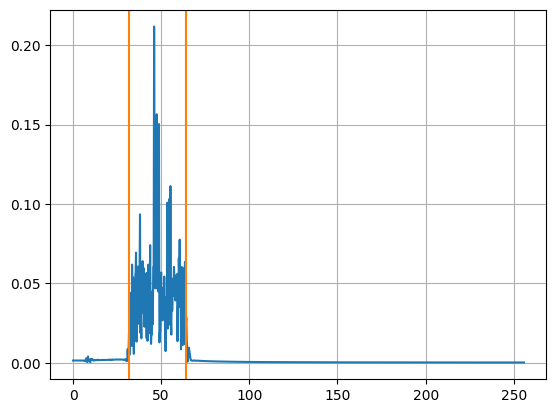

In [12]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X[0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

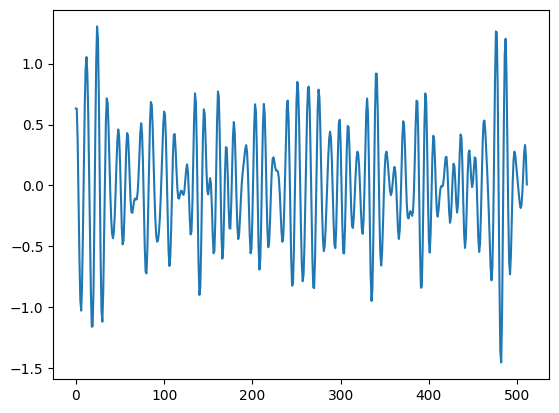

In [13]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        break
plt.plot(X_inj[0][0][0][:512].cpu().numpy())

In [14]:
X_bg.shape

torch.Size([10, 1, 2048])

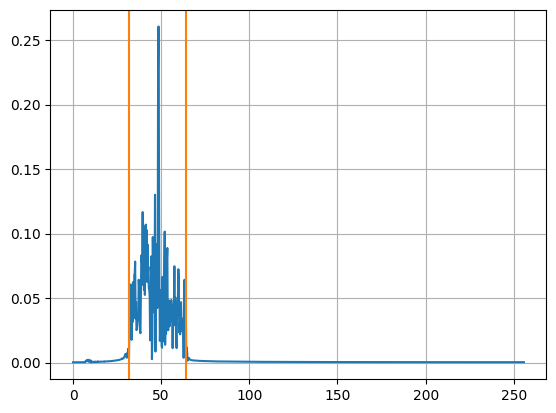

In [18]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X_inj[0][0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

In [16]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()

i = 0
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        [background, _, timeslide_idx], [signals] = batch
        batch = [background.to(torch.device('cuda:0')), 0, timeslide_idx], [signals.to(torch.device('cuda:0'))]
        del background, timeslide_idx, signals
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        del batch
        y_bg = module.score(X_bg)
        del X_bg
        num_views, batch, *shape = X_inj.shape
        X_inj = X_inj.view(num_views * batch, *shape)
        
        y_fg = module.score(X_inj)
        y_fg = y_fg.view(num_views, batch)
        del num_views, batch, shape
        y_fg = y_fg.mean(0)
        y_bg = y_bg.cpu()
        y_fg = y_fg.cpu()
        metric.update(shift, y_bg.cpu(), y_fg.cpu())
        i += 1
        if i > 10:
            break

In [18]:
foreground, background = [], defaultdict(list)
for i, bg, fg in zip(metric.shifts, metric.background, metric.foreground):
    foreground.append(fg)
    background[i.item()].append(bg)
foreground = torch.cat(foreground)

In [19]:
pooled_background = []
for bg in background.values():
    bg = torch.cat(bg).view(1, 1, -1)
    bg = metric.pool(bg).view(-1)
    pooled_background.append(bg)
background = torch.cat(pooled_background)

In [20]:
y_pred = torch.cat([background, foreground])
y = torch.zeros_like(y_pred)
y[len(background) :] = 1
idx = torch.randperm(len(y_pred))
y_pred = y_pred[idx]
y = y[idx]

In [22]:
metric.metric(y_pred, y)

tensor(0.4997)

In [23]:
foreground

tensor([0.3513, 0.3519, 0.3506, 0.3520, 0.3491, 0.3486, 0.3455, 0.3477, 0.3468,
        0.3435, 0.3397, 0.3462, 0.3458, 0.3455, 0.3452, 0.3444, 0.3466, 0.3385,
        0.3427, 0.3419, 0.3409, 0.3451, 0.3449, 0.3460, 0.3444, 0.3484, 0.3460,
        0.3280, 0.3488, 0.3502, 0.3494, 0.3419, 0.3527, 0.3480, 0.3523, 0.3521,
        0.3470, 0.3413, 0.3505, 0.3482, 0.3491, 0.3490, 0.3470, 0.3461, 0.3437,
        0.3487, 0.3415, 0.3480, 0.3491, 0.3484, 0.3519, 0.3381, 0.3521, 0.3521,
        0.3537, 0.3495, 0.3499, 0.3504, 0.3482, 0.3480, 0.3499, 0.3499, 0.3518,
        0.3507, 0.3505, 0.3487, 0.3514, 0.3492, 0.3454, 0.3468, 0.3472, 0.3423,
        0.3469, 0.3458, 0.3466, 0.3466, 0.3470, 0.3494, 0.3471, 0.3484, 0.3450,
        0.3453, 0.3476, 0.3463, 0.3443, 0.3484, 0.3443, 0.3464, 0.3457, 0.3458,
        0.3466, 0.3457, 0.3471, 0.3487, 0.3499, 0.3469, 0.3478, 0.3481, 0.3472,
        0.3492, 0.3511, 0.3493, 0.3480, 0.3520, 0.3532, 0.3544, 0.3558, 0.3547,
        0.3463, 0.3528])

In [21]:
y

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')